In [5]:
# LMFIT
# https://people.duke.edu/~ccc14/sta-663/CalibratingODEs.html

from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%precision 4
plt.style.use('ggplot')

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 300
    # variables        = 2
    chi-square         = 4577.99909
    reduced chi-square = 15.3624131
    Akaike info crit   = 821.570448
    Bayesian info crit = 828.978013
[[Variables]]
    S0:     100 (fixed)
    I0:     1 (fixed)
    R0:     0 (fixed)
    beta:   0.28831242 +/- 0.00171773 (0.60%) (init = 0.01)
    gamma:  0.06984323 +/- 0.00122292 (1.75%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma) =  0.346


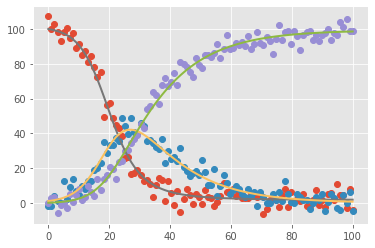

In [13]:
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint

def f(xs, t, ps): #equivalent to ode_model
    
    try:
        beta = ps['beta'].value
        gamma = ps['gamma'].value  
    except:
        beta, gamma = ps
    
    S, I, R = xs  
    N = S + I + R 
    
    dSdt = -beta*S*I/N
    dIdt = beta*S*I/N - gamma*I
    dRdt = gamma*I
     
    return [dSdt, dIdt, dRdt]


def g(t, x0, ps):  #Solution to the de
    
    x = odeint(f, x0, t, args=(ps,)) 
    #number of arguments needs to match the number of coefficients 
    #in each equation
    return x

def residual(ps, ts, data):
    x0 = ps['S0'].value, ps['I0'].value, ps['R0'].value
    model = g(ts, x0, ps)
    
    return (model - data).ravel()

t = np.linspace(0, 100, 100) # t range [0] - [1]; [2] -> num of steps
x0 = np.array([100, 1, 0])  #initial conditions for each equation

# # # # # # # # # # # # Set up testing data # # # # # # # # # # 

beta, gamma = 0.29, 0.07
true_params = np.array((beta, gamma))
data = g(t, x0, true_params)
data += 4*np.random.normal(size=data.shape)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

params = Parameters()
params.add('S0', value = float(100), vary=False)
params.add('I0', value = float(1), vary=False)
params.add('R0', value = float(0), vary=False)
params.add('beta', value=0.01, min=0, max=2)
params.add('gamma', value=0.01, min=0, max=2)

result = minimize(residual, params, args=(t, data), method='leastsq')
final = data + result.residual.reshape(data.shape)

plt.plot(t, data, 'o')
plt.plot(t, final, '-', linewidth = 2);

report_fit(result)